<a href="https://colab.research.google.com/github/serkanishchi/some_works/blob/master/enc_trace_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import Necessary libraries
import os
import sys
import argparse
import logging

import pickle
from collections import defaultdict

import numpy as np
import pandas as pd

if '1' == os.getenv('useGpu'):
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Flatten, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
import keras.backend as K
from keras.utils import np_utils

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import urllib.request

# Download the dataset from Github Repository
training_url = 'https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_train.zip'
test_url = 'https://github.com/Aegon007/adv_topic_data_security/raw/master/network_analysis/data/traffic_trace_test.zip'
urllib.request.urlretrieve(training_url, 'traffic_trace_train.zip')
urllib.request.urlretrieve(test_url, 'traffic_trace_test.zip')

('traffic_trace_test.zip', <http.client.HTTPMessage at 0x7f3ae80ab278>)

In [0]:
import zipfile

# Extract the data
with zipfile.ZipFile('traffic_trace_train.zip', 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile('traffic_trace_test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [0]:
# Load Training Data
trainingData = pd.read_csv("traffic_trace_train.csv", sep='\t')
trainingData=trainingData.to_numpy()
X_train, Y_train = [], []
for i in range(trainingData.shape[0]):
  sample = list(trainingData[i, :])
  one_data = sample[1:-1]
  one_label = sample[-1]
  X_train.append(one_data)
  Y_train.append(one_label)

del trainingData

In [0]:
# Load Test Data 
testData = pd.read_csv("traffic_trace_test.csv", sep='\t')
testData=testData.to_numpy()
X_test, Y_test = [], []
for i in range(testData.shape[0]):
  sample = list(testData[i, :])
  one_data = sample[1:-1]
  one_label = sample[-1]
  X_test.append(one_data)
  Y_test.append(one_label)

del testData

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
NUM_CLASS = len(set(Y_test))
print(NUM_CLASS)

95


In [0]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = np_utils.to_categorical(Y_train, NUM_CLASS)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test = np_utils.to_categorical(Y_test, NUM_CLASS)

In [0]:
params ={
  'optimizer': 'Adam',
  'learning_rate': 0.01,
  'activation1': 'softsign',
  'activation2': 'softsign',
  'activation3': 'selu',
  'activation4': 'selu',
  'drop_rate1': 0.3,
  'drop_rate2': 0.1,
  'drop_rate3': 0.3,
  'drop_rate4': 0.5,
  'decay': 0.1,
  'batch_size': 70,
  'data_dim': 2000,
  'epochs': 500,
  'conv1': 64,
  'conv2': 128,
  'conv3': 256,
  'conv4': 128,
  'pool1': 5,
  'pool2': 3,
  'pool3': 1,
  'pool4': 3,
  'kernel_size1': 15,
  'kernel_size2': 21,
  'kernel_size3': 15,
  'kernel_size4': 11,
  'dense1': 150,
  'dense2': 130,
  'dense1_act': 'selu',
  'dense2_act': 'softsign'
}

In [21]:
layers = [Conv1D(params['conv1'], kernel_size=params['kernel_size1'], activation=params['activation1'], input_shape=(params['data_dim'], 1), use_bias=False, kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool1']),
          Dropout(rate=params['drop_rate1']),

          Conv1D(params['conv2'], kernel_size=params['kernel_size2'], activation=params['activation2'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool2']),
          Dropout(rate=params['drop_rate2']),

          Conv1D(params['conv3'], kernel_size=params['kernel_size3'], activation=params['activation3'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool3']),
          Dropout(rate=params['drop_rate3']),

          Conv1D(params['conv4'], kernel_size=params['kernel_size4'], activation=params['activation4'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          MaxPooling1D(params['pool4']),
          GlobalAveragePooling1D(),

          Dense(params['dense1'], activation=params['dense1_act'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          Dense(params['dense2'], activation=params['dense2_act'], kernel_initializer='glorot_normal'),
          BatchNormalization(),
          Dense(NUM_CLASS, activation='softmax')]

model = Sequential(layers)

print ('Compiling...')
model.compile(loss='categorical_crossentropy',
  optimizer=params['optimizer'],
  metrics=['accuracy'])

Compiling...


In [0]:
modelDir = 'modelDir'
if not os.path.isdir(modelDir):
    os.makedirs(modelDir)
LOG = logging.getLogger('modelDir/cnn_results')

In [23]:

picDir = os.path.join(modelDir, 'pic')
if not os.path.isdir(picDir):
  os.makedirs(picDir)
picPath = os.path.join(picDir, 'cnn_model.png')
from keras.utils import plot_model
plot_model(model, to_file=picPath, show_shapes='True')

print ('Fitting model...')

def lr_scheduler(epoch):
  if epoch % 20 == 0 and epoch != 0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*params['decay'])
    print("lr changed to {}".format(lr*params['decay']))
  return K.get_value(model.optimizer.lr)

modelPath = os.path.join(modelDir, 'cnn_weights_best.hdf5')
checkpointer = ModelCheckpoint(filepath=modelPath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

CallBacks = [checkpointer]
if params['optimizer'] == 'SGD':
  scheduler = LearningRateScheduler(lr_scheduler)
  CallBacks.append(scheduler)

CallBacks.append(EarlyStopping(monitor='val_accuracy', mode='max', patience=6))

Fitting model...


In [18]:
hist = model.fit(X_train, Y_train,
  batch_size=params['batch_size'],
  epochs=params['epochs'],
  validation_split = 0.2,
  verbose=1,
  callbacks=CallBacks)

Train on 60800 samples, validate on 15200 samples
Epoch 1/500
60800/60800 [==============================] - 23s 380us/step - loss: 0.0671 - accuracy: 0.9802 - val_loss: 0.3024 - val_accuracy: 0.9398
Epoch 2/500
  420/60800 [..............................] - ETA: 22s - loss: 0.0404 - accuracy: 0.9810

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


60800/60800 [==============================] - 23s 379us/step - loss: 0.0655 - accuracy: 0.9808 - val_loss: 0.2790 - val_accuracy: 0.9429
Epoch 3/500
60800/60800 [==============================] - 23s 380us/step - loss: 0.0636 - accuracy: 0.9820 - val_loss: 0.2787 - val_accuracy: 0.9464
Epoch 4/500
60800/60800 [==============================] - 23s 383us/step - loss: 0.0644 - accuracy: 0.9811 - val_loss: 0.2846 - val_accuracy: 0.9434
Epoch 5/500
60800/60800 [==============================] - 23s 380us/step - loss: 0.0666 - accuracy: 0.9804 - val_loss: 0.2661 - val_accuracy: 0.9472
Epoch 6/500
60800/60800 [==============================] - 23s 379us/step - loss: 0.0669 - accuracy: 0.9812 - val_loss: 0.2599 - val_accuracy: 0.9484
Epoch 7/500
60800/60800 [==============================] - 23s 378us/step - loss: 0.0636 - accuracy: 0.9812 - val_loss: 0.2810 - val_accuracy: 0.9445
Epoch 8/500
60800/60800 [==============================] - 23s 378us/step - loss: 0.0640 - accuracy: 0.9810 - va

In [19]:
print(hist)

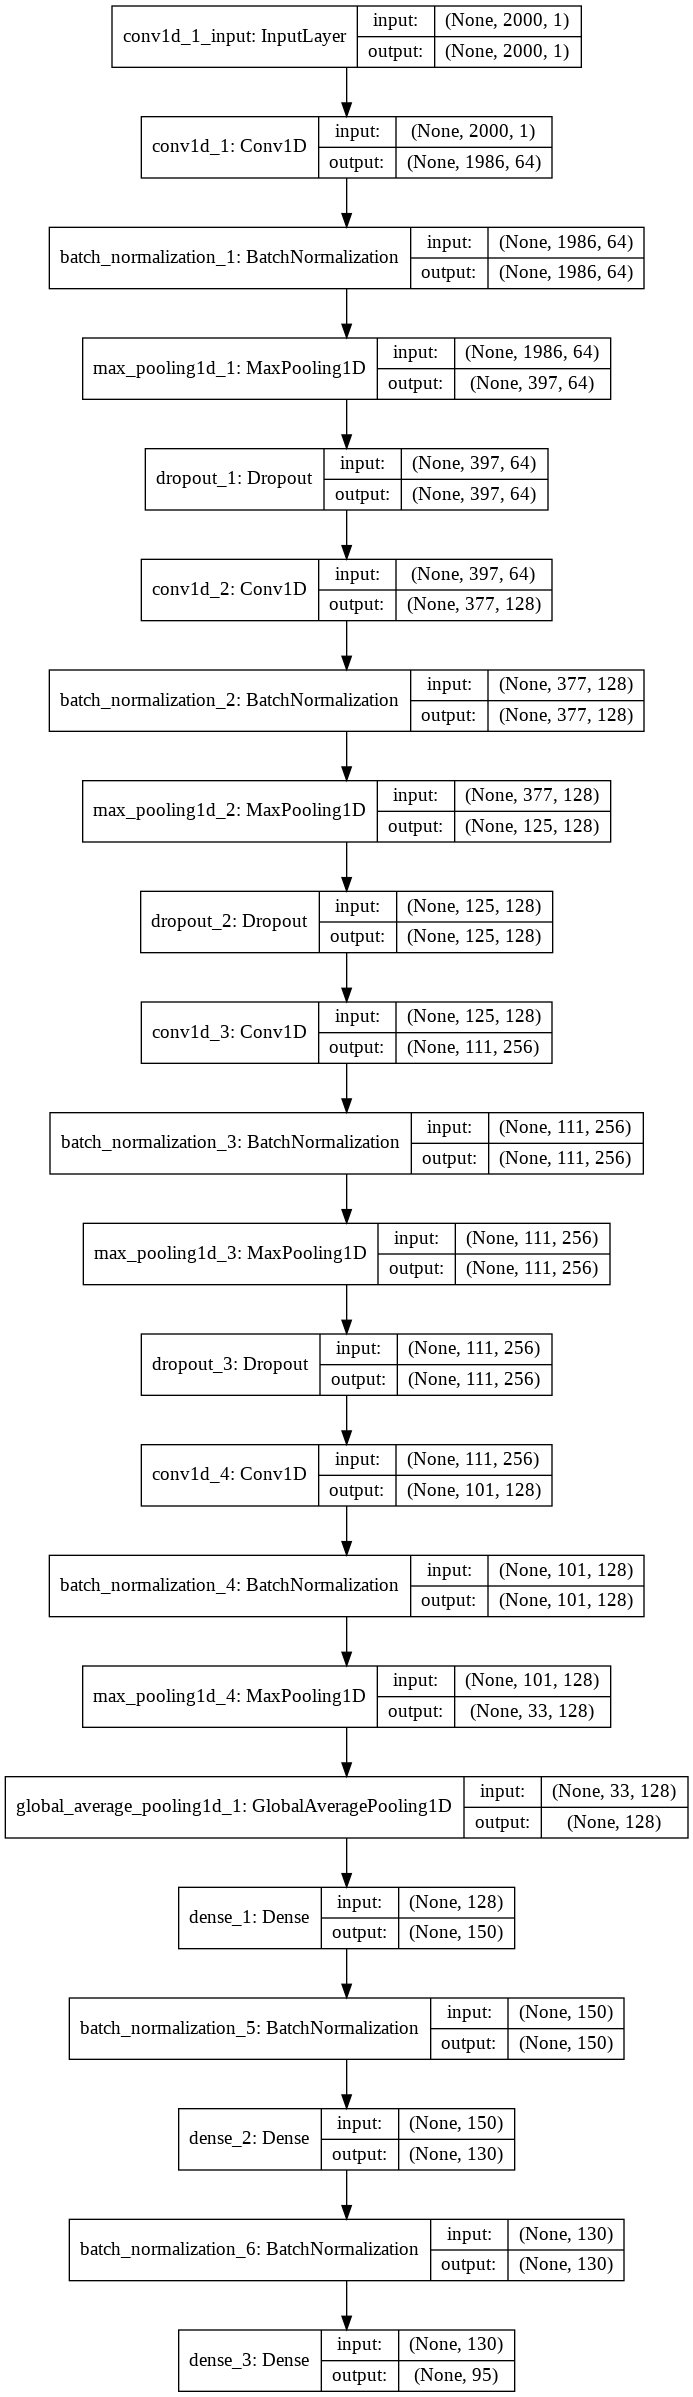

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes='True')

In [0]:
model.save(modelPath)

In [22]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)

print('Test score:', score)
print('Test accuracy:', acc)

9500/9500 [==============================] - 1s 110us/step
Test score: 0.26277467473716426
Test accuracy: 0.9464210271835327


In [24]:
model.load_weights(modelPath)

OSError: ignored